# <span style="color:#2834d4">매개변수 갱신</span>

최적화(optimization): 손실함수의 값을 가능한 낮추는 매개변수를 찾는 것, 즉 매개변수의 최적값을 찾는 문제를 푸는 것

## 1. 확률적 경사 하강법 (SGD)

### $\mathbf{W} \gets \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}$

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

사용방법 - 수도코드
```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

## 2. 모멘텀 (Momentum)

### $\mathbf{v} \gets \alpha \mathbf{v} - \eta \frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{W} \gets \mathbf{W} + \mathbf{v}$

$\mathbf{v}$ : velocity

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

## 3. AdaGrad

learning rate decay (학습률 감소)
- 학습률을 점차 줄여가는 방법으로, 처음에는 크게 학습하다 조금씩 작게 학습하는 것.
- learning rate 값이 너무 작으면 학습시간이 길어지고, 너무 크면 발산하여 학습이 제대로 이루어지지 않음.

Adagrad : 개별 매개변수에 적응적으로 (adaptive) 학습률을 조정하면서 학습 진행
- 과거의 기울기를 제곱하여 계속 더해가면서 학습을 진행할수록 갱신 강도가 약해짐.

### $\mathbf{h} \gets \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{W} \gets \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}$

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 4. RMSProp

과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영하여 과거 기울기의 반영 규모를 기하급수적으로 감소시킴
- AdaGrad로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않는 문제를 개선한 기법

### $\mathbf{h} \gets \rho \mathbf{h} + (1-\rho) \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{W} \gets \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}$

In [4]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 5. Adam

momentum + RMSProp

### $\mathbf{m} \gets \beta_1 \mathbf{m} + (1-\beta_1)\frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{v} \gets \beta_2 \mathbf{v} + (1-\beta_2)\frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}$
### $\hat{\mathbf{m}} \gets \frac{m}{(1-\beta_1^t)}, \hat{\mathbf{v}} \gets \frac{v}{(1-\beta_2^t)}$
### $\mathbf{W} \gets \mathbf{W} - \eta \frac{\hat{\mathbf{m}}}{\sqrt{\hat{\mathbf{v}}}}$

In [5]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.t += 1
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]  # 일차 모멘텀
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)  # 이차 모멘텀
            m_unbias = self.m[key] / (1.0 - self.beta1**self.t)  # bias correction
            v_unbias = self.v[key] / (1.0 - self.beta2**self.t)  # bias correcion
            params[key] -= self.lr *  m_unbias / (np.sqrt(v_unbias) + 1e-7)

## 6. 갱신 방법 비교

<img src="img/compare_optimizer1.png">

**MNIST 데이터셋으로 본 갱신 방법 비교**

<img src="img/compare_optimizer2.png" align='left' width="30%" height="30%">

|iteration|SGD|Momentum|AdaGrad|Adam|
|:---:|:---:|:---:|:---:|:---:|
|0|2.311864598015662|2.385649391761|2.1177254991191226|2.1398345892056962|
|400|0.397280701092698|0.12505988816582034|0.0494271112834781|0.0792357420915904|
|900|0.22393582337790538|0.11924298272985065|0.02922040503059991|0.07950928723895823|
|1400|0.1469758364578464|0.0855866555229981|0.03847798248486493|0.04701864922897751|
|1900|0.25185541115620247|0.034430270259498776|0.016049158619572533|0.01428691276185064|

# <span style="color:#2834d4">가중치의 초깃값</span>

가중치 감소(weight decay): 가중치 매개변수의 값이 작아지도록 학습하는 방법
- 가중치 값을 작게하여 overfitting 방지

## 1. 초깃값을 0으로 하면? (= 균일한 값으로 설정하면?)

- 동일한 layer의 모든 뉴런에 같은 값이 입력되고 역전파에서도 가중치가 모두 똑같이 갱신되기 때문에, 가중치를 여러 개 갖는 의미를 사라지게 함

## 2. 은닉층의 활성화값 분포 - sigmoid 사용했을 때

- 활성화값: 활성화 함수의 출력 데이터

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def activation_value_dist(func, n):
    x = np.random.randn(1000, 100)  # 1000개의 데이터
    node_num = 100  # 각 은닉층의 노드(뉴런) 수
    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과(활성화값)를 저장
   
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
        w = np.random.randn(node_num, node_num) * n
        a = np.dot(x, w)
        z = func(a)
        activations[i] = z
        
    plt.figure(figsize=(15,4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1)+"-layer")
        plt.hist(a.flatten(), 30, range=(0,1)) 
    plt.show()

In [7]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

### 표준편차를 1로 설정
- 기울기 소실 (gradient vanishing) 발생
    - 시그모이드 함수의 경우 출력이 0또는 1에 가까워지면 그 미분은 0에 다가가서 역전파의 기울기 값이 점점 작아지다 사라짐

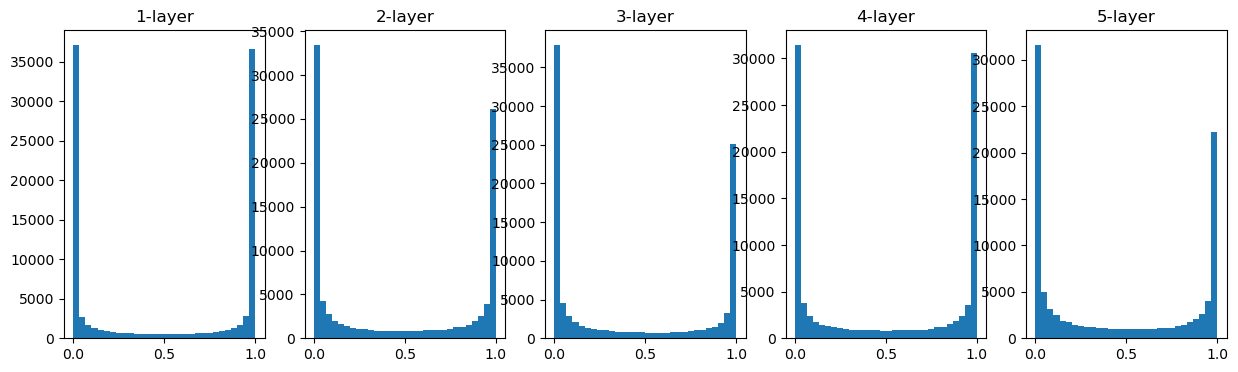

In [8]:
activation_value_dist(sigmoid, 1)

### 표준편차를 0.01로 설정
- 활성화값이 0.5부근에 집중되어 기울기 소실 문제가 발생하지 않음
- 그러나 활성화값들이 치우치면 표현력을 제한한다는 관점에서 문제가 됨
    - 다수의 뉴런이 거의 같은 값을 출력하고 있어 뉴런을 여러 개 둔 의미가 없어짐

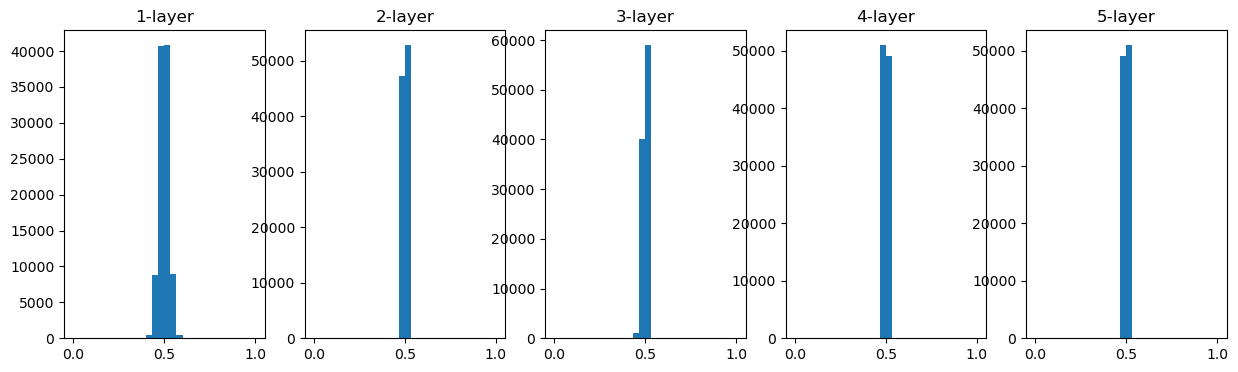

In [9]:
activation_value_dist(sigmoid, 0.01)

### Xavier initalization
- 앞 계층의 노드가 n개라면, 표준편차가 $\frac{1}{\sqrt{n}}$인 분포를 사용
- 층이 깊어질 수록 형태가 다소 일그러지지만 앞에서 본 방식보다 넓게 분포됨을 알 수 있음

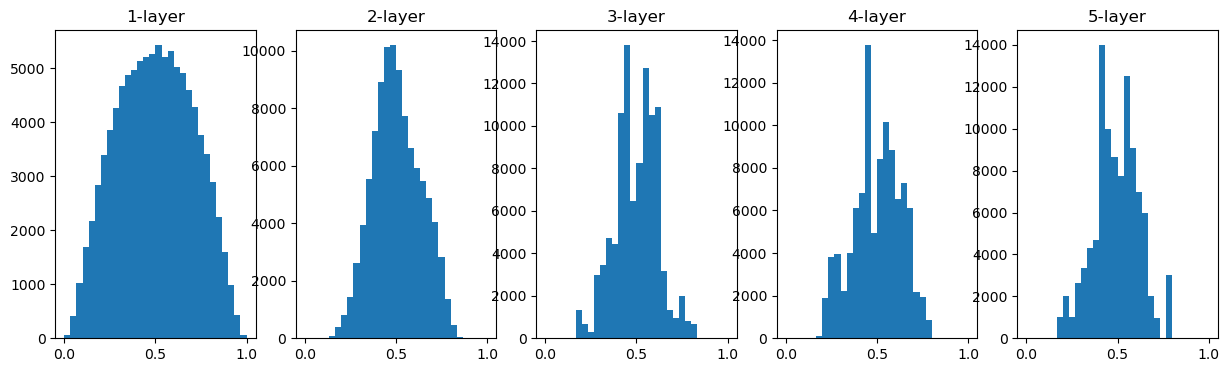

In [10]:
node_num = 100
activation_value_dist(sigmoid, np.sqrt(1.0 / node_num))

## 3. ReLU를 사용할 때의 가중치 초기값

In [11]:
def ReLU(x):
    return np.maximum(0, x)

### 표준편차를 0.01로 설정
- 각 층의 활성화값들은 아주 작은 값들이고 이는 역전파때 가중치의 기울기 역시 작아진다는 뜻
- 실제로도 학습이 거의 이루어지지 않을 것

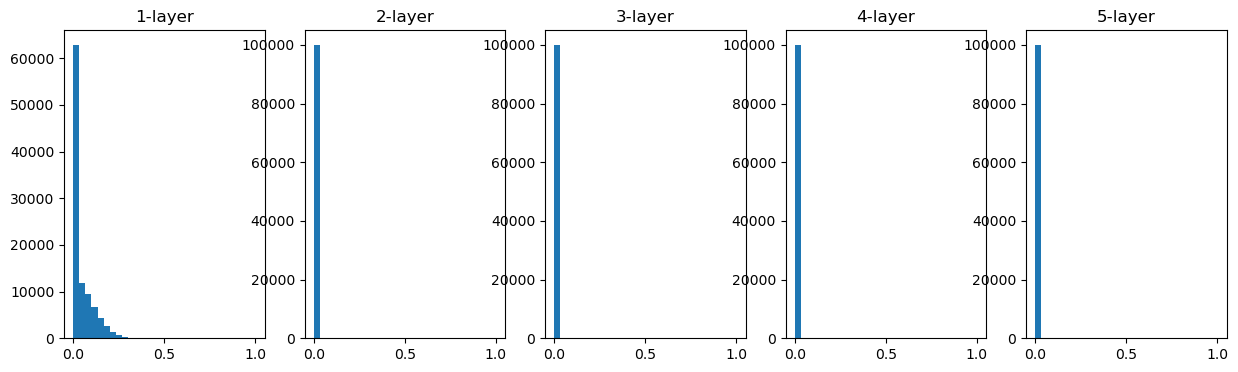

In [12]:
activation_value_dist(ReLU, 0.01)

### Xavier initalization
- 층이 깊어지면서 치우침이 조금씩 커짐
- 실제로 층이 깊어지면 활성화값들의 치우침도 커지고 학습할 때 기울기 소실 문제를 일으킴

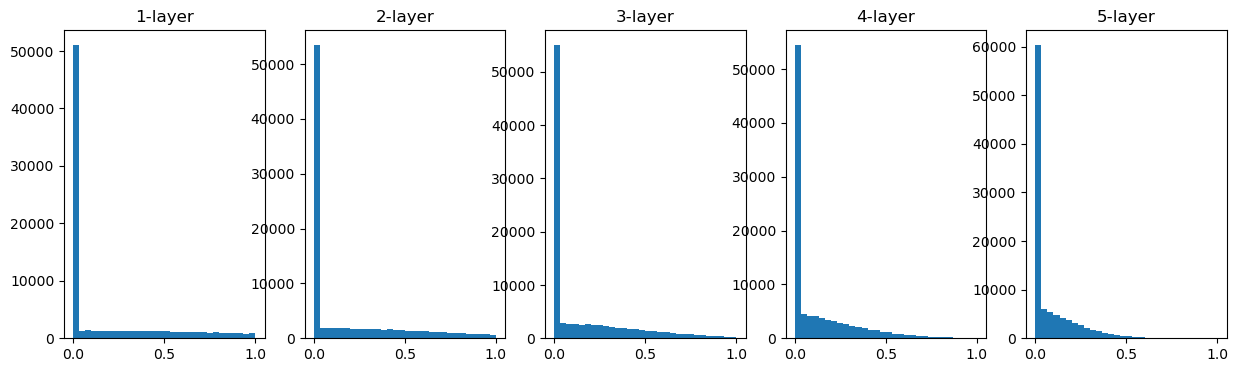

In [13]:
node_num = 100
activation_value_dist(ReLU, np.sqrt(1.0 / node_num))

### He initialization
- 앞 계층의 노드가 n개라면, 표준편차가 $\frac{2}{\sqrt{n}}$인 분포를 사용
    - ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 직감적으로 해석할 수 있음
- 모든 층에서 균일하게 분포되기 때문에 역전파때도 적절한 값이 나올 것으로 기대할 수 있음

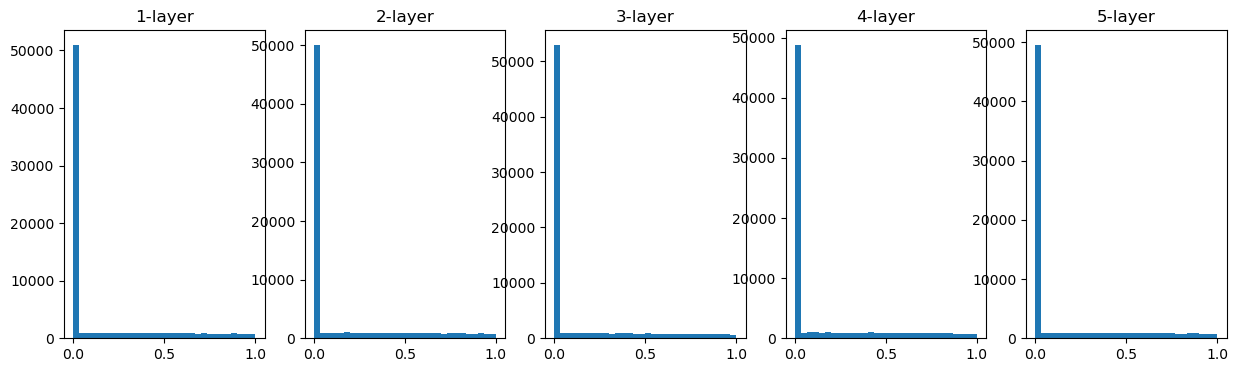

In [14]:
node_num = 100
activation_value_dist(ReLU, np.sqrt(2.0 / node_num))

## 4. MNIST 데이터셋으로 본 가중치 초깃값 비교

- 층별 뉴런 수가 100개인 5층 신경망에서 ReLU 사용

<img src="img/weight_init_compare.png" align='left' width="40%" height="40%">

|iteration|std=0.01|Xavier|He|
|:---:|:---:|:---:|:---:|
|0|2.302544725029941|2.3085964538202006|2.3380467942566465|
|400|2.303284375915534|1.4752362788755917|0.40676313851907686|
|900|2.3024281441488865|0.42736497442224114|0.2458057090695743|
|1400|2.302129356976167|0.4022931155339009|0.34895854989631847|
|1900|2.2979235879617343|0.3450216887304113|0.22400708029691246|

# <span style="color:#2834d4">배치 정규화</span>